# Anomaly Detection Challenge

This notebook experiments with different anomaly detection algorithms on the HEP dataset.
We'll compare Isolation Forest and Flow Matching approaches.

In [1]:
# Import necessary libraries
import numpy as np
import os
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    accuracy_score,
    RocCurveDisplay,
)
import time

# Import fAD components
from fad.data.loaders import _load_h5_challenge_dataset
from fad.data.preprocessing import Preprocessor, StandardScalerFunction, TSNEFunction
from fad.models.statistical import IsolationForestDetector
from fad.models.flow_matching import FlowMatchingAnomalyDetector

## 1. Data Loading and Exploration

In [2]:
# Set paths to dataset files
path_bkg = (
    "/home/fvaselli/Documents/PHD/fAD/fad/data/ad_challenge/background_for_training.h5"
)
path_anom = "/home/fvaselli/Documents/PHD/fAD/fad/data/ad_challenge/Ato4l_lepFilter_13TeV_filtered.h5"

# Load challenge datasets
print("Loading datasets...")
dataset = _load_h5_challenge_dataset(path_bkg, path_anom, n_train=100000, n_test=50000)

# Print dataset information
print(f"Training set shape: {dataset.train.shape}")
print(f"Test set shape: {dataset.test.shape}")
print(f"Number of anomalies in test set: {np.sum(dataset.test_labels)}")


Loading datasets...
Training set shape: (100000, 76)
Test set shape: (100000, 76)
Number of anomalies in test set: 50000.0


## 2. Data Preprocessing

In [3]:
# Preprocess data with standardization
print("Preprocessing data...")
preprocessor = Preprocessor([StandardScalerFunction()])
X_train = preprocessor.transform(dataset.train, fit=True)
X_test = preprocessor.transform(dataset.test)
print("Done")

Preprocessing data...
Done


## 3. t-SNE Visualization

t-SNE reduces dimensionality while preserving local structure, helping us visualize high-dimensional data.

In [4]:
# Visualize data with t-SNE (subsample for speed)
# print("Visualizing data with t-SNE (this may take a while)...")
# subsample_size = min(5000, len(X_test))
# indices = np.random.choice(len(X_test), subsample_size, replace=False)

# tsne_preprocessor = Preprocessor([TSNEFunction(n_components=2)])
# X_test_tsne = tsne_preprocessor.transform(X_test[indices], fit=True)
# y_test_tsne = dataset.test_labels[indices]

# # Plot t-SNE visualization
# plt.figure(figsize=(10, 8))
# plt.scatter(
#     X_test_tsne[y_test_tsne == 0, 0],
#     X_test_tsne[y_test_tsne == 0, 1],
#     c="blue",
#     alpha=0.5,
#     label="Normal",
# )
# plt.scatter(
#     X_test_tsne[y_test_tsne == 1, 0],
#     X_test_tsne[y_test_tsne == 1, 1],
#     c="red",
#     alpha=0.5,
#     label="Anomaly",
# )
# plt.title("t-SNE Visualization of Test Data")
# plt.legend()
# plt.tight_layout()
# plt.show()

## 4. Train and Evaluate Models

We'll train and evaluate two models:
1. Isolation Forest (traditional algorithm)
2. Flow Matching (advanced generative model)

In [5]:
# Dictionary to store results
results = {}

### 4.1 Isolation Forest

In [6]:
print("Training Isolation Forest...")
start_time = time.time()
iso_forest = IsolationForestDetector(contamination=0.01)
iso_forest.fit(X_train)
iso_time = time.time() - start_time
print(f"Training time: {iso_time:.2f} seconds")

# Predict anomaly scores
iso_scores = iso_forest.predict(X_test)
iso_auc = roc_auc_score(dataset.test_labels, iso_scores)
iso_ap = average_precision_score(dataset.test_labels, iso_scores)
iso_accuracy = accuracy_score(dataset.test_labels, iso_scores < 0)
print(f"Accuracy: {iso_accuracy:.4f}")
print(f"AUC-ROC: {iso_auc:.4f}")
print(f"Average Precision: {iso_ap:.4f}")

results["Isolation Forest"] = {
    "scores": iso_scores,
    "auc": iso_auc,
    "ap": iso_ap,
    "time": iso_time,
}

Training Isolation Forest...
Training time: 0.50 seconds
Accuracy: 0.4454
AUC-ROC: 0.8759
Average Precision: 0.8592


In [7]:
print(X_train.shape[1])

76


### 4.2 Flow Matching

In [8]:
print("Training Flow Matching (this may take a while)...")
# load the model config from the config file
# use absolute path to avoid issues with relative paths: get my parent folder, then go to fad/models/configs/flow_matching.yaml
config_path = "../fad/models/configs/flow_matching.yaml"
with open(config_path, "r") as f:
    config = yaml.safe_load(f)
start_time = time.time()
flow_matching = FlowMatchingAnomalyDetector(
    input_dim=X_train.shape[1],
    hidden_dim=config["hidden_dim"],
    model_type=config["model_type"],
    num_layers=config["num_layers"],
    dropout_rate=config["dropout_rate"],
    use_batch_norm=config["use_batch_norm"],
    lr=config["lr"],
    batch_size= config["batch_size"],
    iterations=config["iterations"],
    print_every=config["print_every"],
    device=config["device"],
)
flow_matching.fit(X_train)
flow_time = time.time() - start_time
print(f"Training time: {flow_time:.2f} seconds")

# Predict anomaly scores
flow_scores, _ = flow_matching.predict(X_test, mode="ODE")
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores[dataset.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores[dataset.test_labels == 0]):.4f}"
)
print(
    f"Mean score for anomalous samples: {np.mean(flow_scores[dataset.test_labels == 1]):.4f}"
)
print(
    f"Std score for anomalous samples: {np.std(flow_scores[dataset.test_labels == 1]):.4f}"
)
flow_auc = roc_auc_score(dataset.test_labels, flow_scores)
flow_ap = average_precision_score(dataset.test_labels, flow_scores)
flow_accuracy = accuracy_score(dataset.test_labels, flow_scores > 150)
print(f"Accuracy: {flow_accuracy:.4f}")
print(f"AUC-ROC: {flow_auc:.4f}")
print(f"Average Precision: {flow_ap:.4f}")

results["Flow Matching"] = {
    "scores": flow_scores,
    "auc": flow_auc,
    "ap": flow_ap,
    "time": flow_time,
}

Training Flow Matching (this may take a while)...
| iter     50 |  1.08 ms/step | loss    2.802 
| iter    100 |  1.06 ms/step | loss    1.435 
| iter    150 |  2.56 ms/step | loss    1.431 
| iter    200 |  1.52 ms/step | loss    1.179 
| iter    250 |  1.35 ms/step | loss    1.467 
| iter    300 |  1.06 ms/step | loss    1.242 
| iter    350 |  1.07 ms/step | loss    1.522 
| iter    400 |  1.21 ms/step | loss    1.184 
| iter    450 |  1.41 ms/step | loss    1.610 
| iter    500 |  1.06 ms/step | loss    1.222 
| iter    550 |  1.02 ms/step | loss    1.129 
| iter    600 |  1.59 ms/step | loss    1.268 
| iter    650 |  2.19 ms/step | loss    2.174 
| iter    700 |  2.18 ms/step | loss    1.206 
| iter    750 |  2.16 ms/step | loss    1.086 
| iter    800 |  2.17 ms/step | loss    0.998 
| iter    850 |  2.17 ms/step | loss    0.881 
| iter    900 |  2.23 ms/step | loss    1.484 
| iter    950 |  2.16 ms/step | loss    1.034 
| iter   1000 |  2.24 ms/step | loss    0.951 
Training t

In [10]:
# save the model, then load it
flow_matching.save("flow_matching_model.pt")
flow_matching_loaded  = FlowMatchingAnomalyDetector(
    input_dim=X_train.shape[1],
    hidden_dim=config["hidden_dim"],
    model_type=config["model_type"],
    num_layers=config["num_layers"],
    dropout_rate=config["dropout_rate"],
    use_batch_norm=config["use_batch_norm"],
    lr=config["lr"],
    batch_size= config["batch_size"],
    iterations=config["iterations"],
    print_every=config["print_every"],
    device=config["device"],
)
flow_matching_loaded.load("flow_matching_model.pt")
# Predict anomaly scores
flow_scores_loaded, _ = flow_matching_loaded.predict(X_test, mode="ODE")
# print mean and std of scores for normal and anomalous samples
print(
    f"Mean score for normal samples: {np.mean(flow_scores_loaded[dataset.test_labels == 0]):.4f}"
)
print(
    f"Std score for normal samples: {np.std(flow_scores_loaded[dataset.test_labels == 0]):.4f}"
)


Model saved to flow_matching_model.pt
Model loaded from flow_matching_model.pt
Mean score for normal samples: 126.7591
Std score for normal samples: 2906.4543


## 5. Model Comparison and Visualization

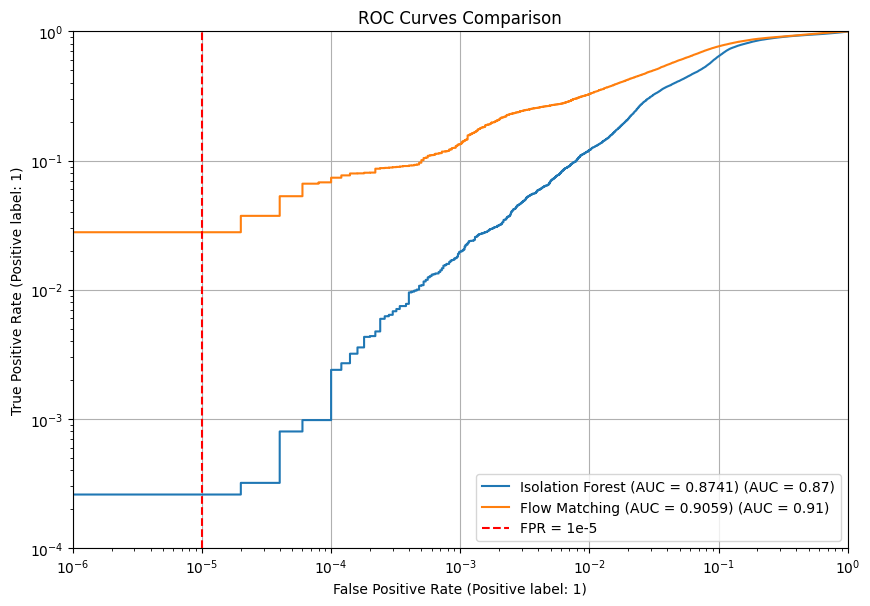

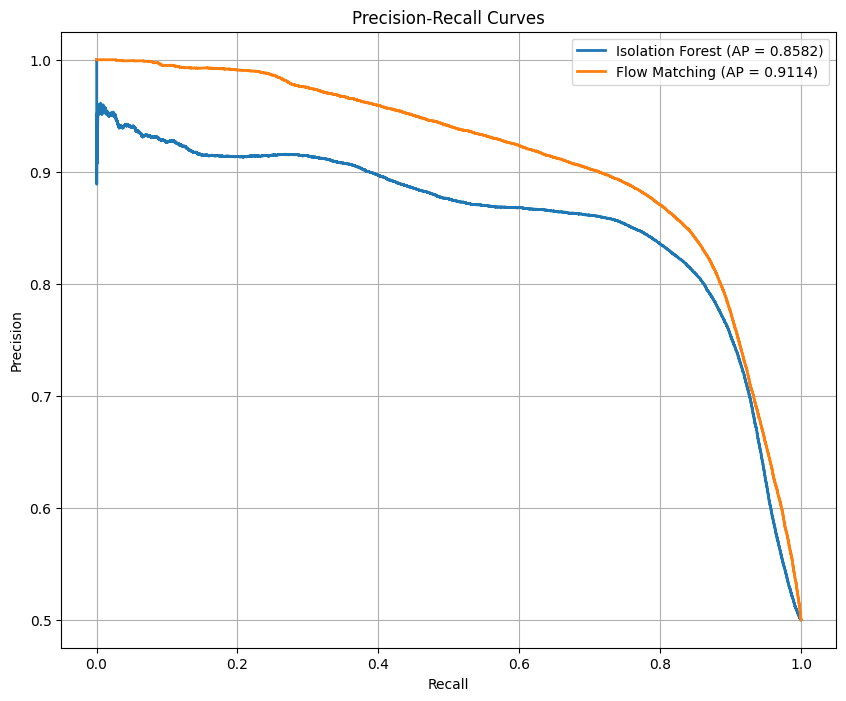

In [9]:
# Compare ROC curves
plt.figure(figsize=(10, 8))

for name, result in results.items():
    RocCurveDisplay.from_predictions(
        dataset.test_labels,
        result["scores"],
        name=f"{name} (AUC = {result['auc']:.4f})",
        ax=plt.gca(),
    )

plt.axvline(x=1e-5, color="red", linestyle="--", label="FPR = 1e-5")
plt.xscale("log")
plt.yscale("log")
plt.xlim([1e-6, 1])
plt.ylim([1e-4, 1])
plt.title("ROC Curves Comparison")
plt.grid(True)
plt.legend()
plt.show()

# Compare Precision-Recall curves
plt.figure(figsize=(10, 8))
for name, result in results.items():
    precision, recall, _ = precision_recall_curve(dataset.test_labels, result["scores"])
    plt.plot(recall, precision, lw=2, label=f"{name} (AP = {result['ap']:.4f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.grid(True)
plt.show()

## 6. Score Distributions

mean score for normal samples: 76.41636657714844
mean score for anomalous samples: 347.18505859375


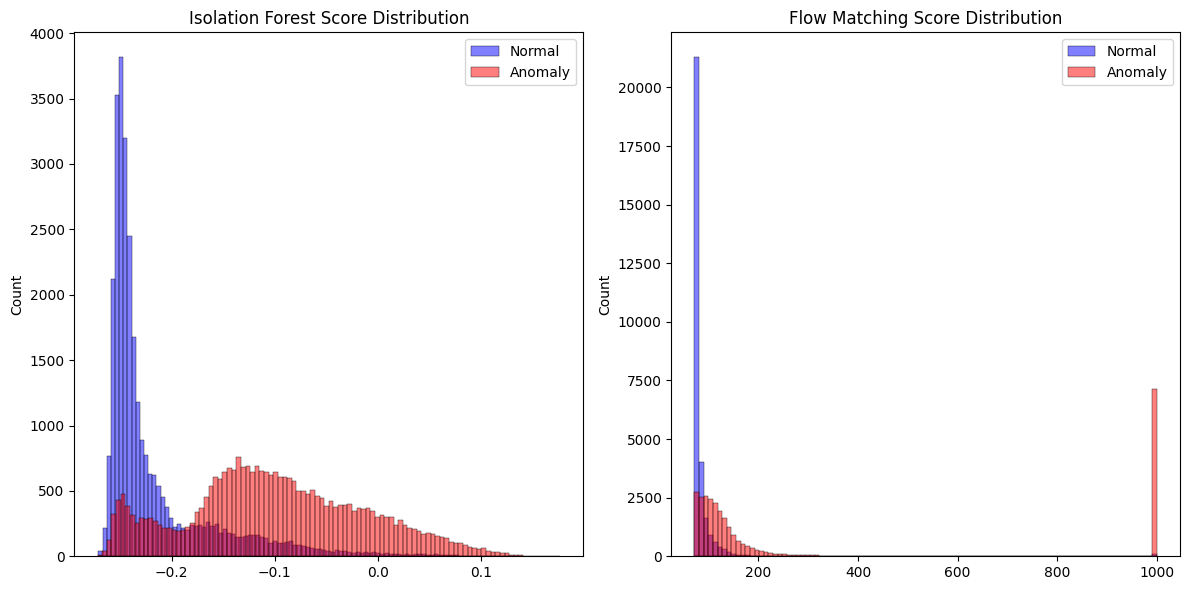

In [54]:
# Visualize anomaly scores distribution
plt.figure(figsize=(12, 6))

for i, (name, result) in enumerate(results.items(), 1):
    plt.subplot(1, len(results), i)

    # Separate scores for normal and anomaly classes
    normal_scores = result["scores"][dataset.test_labels == 0]
    anomaly_scores = result["scores"][dataset.test_labels == 1]

    if any(anomaly_scores > 1000):
        anomaly_scores[anomaly_scores > 1000] = 1000
        normal_scores[normal_scores > 1000] = 1000
        print(f"mean score for normal samples: {np.median(normal_scores)}")
        print(f"mean score for anomalous samples: {np.mean(anomaly_scores)}")
    # Plot histograms
    sns.histplot(normal_scores, color="blue", alpha=0.5, label="Normal", bins=100)
    sns.histplot(anomaly_scores, color="red", alpha=0.5, label="Anomaly", bins=100)

    plt.title(f"{name} Score Distribution")
    plt.legend()

plt.tight_layout()
plt.show()

## 7. Results Summary

In [ ]:
# Create a summary table
print("==== Summary of Results ====")
print(f"{'Model':<20} {'AUC-ROC':<10} {'Avg Precision':<15} {'Training Time (s)':<15}")
print("-" * 60)
for name, result in results.items():
    print(
        f"{name:<20} {result['auc']:<10.4f} {result['ap']:<15.4f} {result['time']:<15.2f}"
    )